In [1]:
from PIL import Image
from pathlib import Path
import math
import torch
import torchvision as tv
import torchvision.transforms.functional as tvf
torch.set_grad_enabled(False)

from lvae import get_model

device = torch.device('cuda:1')

/home/jma/miniconda3/envs/softvq/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jma/miniconda3/envs/softvq/lib/python3.10/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [2]:
def run_progressive_coding(model, img_path):
    im = im = tvf.to_tensor(Image.open(img_path)).unsqueeze(0).to(device=device)
    nB, imC, imH, imW = im.shape

    stats_all = model.forward_get_latents(im)

    progressive_decodings = []
    L = len(stats_all)
    for keep in range(1, L+1):
        latents = [stat['z'] if (i < keep) else None for (i,stat) in enumerate(stats_all)]
        kl_divs = [stat['kl'] for (i,stat) in enumerate(stats_all) if (i < keep)]
        kl = sum([kl.sum(dim=(1,2,3)) for kl in kl_divs]) / (imH * imW) * math.log2(math.e)
        sample = model.cond_sample(latents, temprature=0)
        progressive_decodings.append(sample.squeeze(0))
        print(f'Keep={keep}, bpp={kl.item()}')

    return torch.stack(progressive_decodings, dim=0)

## Image 1

Downloading: "https://huggingface.co/duanzh0/my-model-weights/resolve/main/qres34m/qres34m-lmb2048.pt" to /home/jma/.cache/torch/hub/checkpoints/qres34m-lmb2048.pt
100%|██████████| 130M/130M [00:05<00:00, 26.8MB/s] 


Keep=1, bpp=0.010392916388809681
Keep=2, bpp=0.04203999787569046
Keep=3, bpp=0.07201888412237167
Keep=4, bpp=0.22939178347587585
Keep=5, bpp=0.36845794320106506
Keep=6, bpp=0.5077086687088013
Keep=7, bpp=1.1555534601211548
Keep=8, bpp=1.693187952041626
Keep=9, bpp=2.0939624309539795
Keep=10, bpp=3.4289426803588867
Keep=11, bpp=4.986048698425293
Keep=12, bpp=5.489867687225342


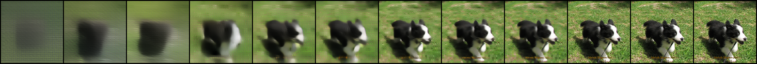

In [3]:
# initialize model
model = get_model('qres34m', lmb=2048, pretrained=True)
model = model.to(device=device).eval()

# run progressive coding
ims = run_progressive_coding(model, img_path='../../images/collie128.png')
im = tv.utils.make_grid(ims, nrow=12)
tvf.resize(tvf.to_pil_image(im), size=64)

## Image 2

Keep=1, bpp=0.00814720056951046
Keep=2, bpp=0.06083941087126732
Keep=3, bpp=0.09832342714071274
Keep=4, bpp=0.25045549869537354
Keep=5, bpp=0.33536332845687866
Keep=6, bpp=0.4313617944717407
Keep=7, bpp=0.5422593951225281
Keep=8, bpp=0.8233409523963928
Keep=9, bpp=1.018266201019287
Keep=10, bpp=1.1474051475524902
Keep=11, bpp=1.3251471519470215
Keep=12, bpp=1.4290088415145874


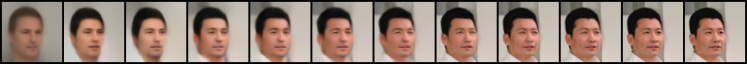

In [4]:
# initialize model
model = get_model('qres17m', lmb=1024, pretrained=True)
model = model.to(device=device).eval()

# run progressive coding
ims = run_progressive_coding(model, img_path='../../images/celeba-201881.png')
im = tv.utils.make_grid(ims, nrow=12)
tvf.resize(tvf.to_pil_image(im), size=64)